This dataset, composed of 440 sound recordings, contains meows emitted by cats in different contexts. Specifically, 21 cats belonging to 2 breeds (Maine Coon and European Shorthair) have been repeatedly exposed to three different stimuli that act as labels for prediction:

* Waiting for food;
* Isolation in unfamiliar environment;
* Brushing (being brushed affectionately by the owner).

Naming conventions follow the pattern 
* L[label]_
* CID[Cat ID]_
* BB[Cat Breed]_
* SS[Sex]_
* OID[Owner ID]_
* R[Recording Session]
* XX[Meow counter].

The unique values are available in the 'dataset' folder description.

# 1.Import and parse file name to csv

In [1]:
import pandas as pd
import os

In [2]:
path = os.getcwd()
audio_file_path = os.path.join(path,'data\\raw_wave')
label_folder = ['Brushing','Food','Environment']

In [3]:
csv_data = []

for label in label_folder:
    for file in os.listdir(os.path.join(audio_file_path,label)):
        file.split('_')
        csv_data.append(file.split('_'))
df = pd.DataFrame(data = csv_data, columns = ['label','Cat_id','Cat_breed','Sex','Owner_id','Recording_session_Meow_counter'])

In [4]:
df.head()

,label,Cat_id,Cat_breed,Sex,Owner_id,Recording_session_Meow_counter
0,B,ANI01,MC,FN,SIM01,101.wav
1,B,ANI01,MC,FN,SIM01,102.wav
2,B,ANI01,MC,FN,SIM01,103.wav
3,B,ANI01,MC,FN,SIM01,301.wav
4,B,ANI01,MC,FN,SIM01,302.wav


### Section conclusion: data comsist of 440 audio files(.wav) of cat calls from two species and 3 behaviors. The target of this task is to use these files to train a model that can coorectly classify the behavior based on audio input. 

# 2.Visualize categorical data to check for imbalance

In [5]:
import seaborn as sns

[Text(0.5, 1.0, 'label count')]

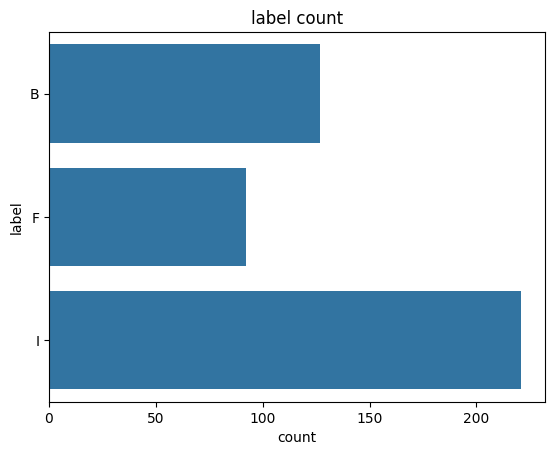

In [6]:
sns.countplot(data = df['label']).set(title='label count')

[Text(0.5, 1.0, 'label count')]

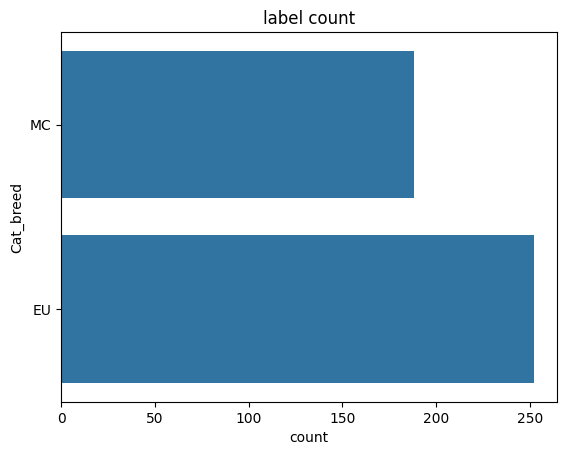

In [7]:
sns.countplot(data = df['Cat_breed']).set(title='label count')

### Section Conclusion: The target variable is imbalanced. moving forward this problem will have to be addressed.

# 3.Transfering audio file to spectrogram and convert this problem into one that may be solved by computer vision.

In [8]:
import tensorflow as tf 
import tensorflow_io as tfio
import matplotlib.pyplot as plt

In [9]:
spec_file_path = os.path.join(path,'data\\spectrogram')
spec_file_path

'C:\\Users\\User\\Desktop\\Side_project\\Computer_vision\\Meow_classification\\data\\spectrogram'

In [10]:
def read_audio_file(filename):
    
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    
    return wav

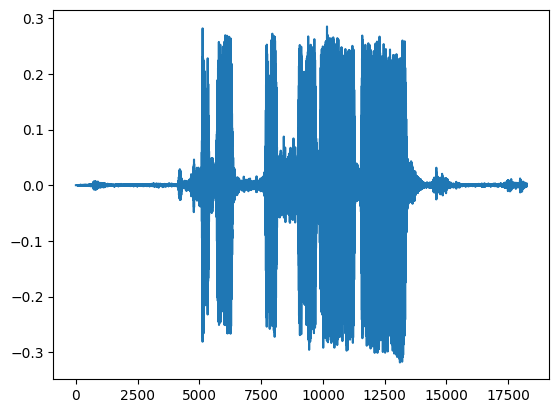

In [11]:
wave = read_audio_file(audio_file_path + '\\Brushing\\B_ANI01_MC_FN_SIM01_101.wav')
plt.plot(wave)

In [12]:
lengths = []
for label in label_folder:
    for file in os.listdir(os.path.join('data\\raw_wave', label)):
        tensor_wave = read_audio_file(os.path.join('data\\raw_wave', label, file))
        lengths.append(len(tensor_wave))
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=14648>

In [13]:
def spectrogram_builder(file_path,label):
    wav = read_audio_file(file_path)
    wav = wav[:20000]
    zero_padding = tf.zeros([20000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [14]:
# data\raw_wave\Brushing\B_ANI01_MC_FN_SIM01_101.wav
for label in label_folder:
    counter = 0
    for file in os.listdir(os.path.join('data\\raw_wave', label)):
        
        file_path = os.path.join('data\\raw_wave', label, file)
        save_path = os.path.join(spec_file_path, label, label+'_'+str(counter))
        counter+=1
        
        spectrogram, label = spectrogram_builder(file_path,label)
        plt.figure(figsize=(30,20))
        plt.imshow(tf.transpose(spectrogram)[0])
        plt.axis('off')
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
        plt.close()
        
#         plt.figure(figsize=(30,20))
#         plt.imshow(tf.transpose(spectrogram)[0])
#         plt.show()
#     break

# 4.Training the model

In [15]:
batch_size = 32
img_height = 616
img_width = 257

In [16]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    spec_file_path,
    subset="training",
    validation_split=0.2,
    image_size=(img_height,img_width),
    seed=123,
    batch_size=batch_size,
    label_mode='categorical')

val_ds = tf.keras.utils.image_dataset_from_directory(
    spec_file_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size,
    label_mode='categorical')

Found 440 files belonging to 3 classes.
Using 352 files for training.
Found 440 files belonging to 3 classes.
Using 88 files for validation.


In [17]:
class_names = train_ds.class_names
print(class_names)

['Brushing', 'Environment', 'Food']


In [18]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 616, 257, 3)
(32, 3)


In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
import numpy as np

In [21]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.003921569 0.96470594


In [22]:
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPooling2D

In [23]:
model=Sequential()

model.add(Conv2D(filters=32, kernel_size = (3,3), activation="relu", input_shape=(616,257,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# model.add(Conv2D(filters=32, kernel_size = (3,3), activation="relu"))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
# model.add(MaxPooling2D(pool_size=(2,2)))

    
model.add(Flatten())
model.add(Dense(128,activation="relu"))
    
model.add(Dense(3,activation="softmax"))
    
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [24]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 614, 255, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 307, 127, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 307, 127, 32)      0         
                                                                 
 flatten (Flatten)           (None, 1247648)           0         
                                                                 
 dense (Dense)               (None, 128)               159699072 
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                        

In [ ]:
hist = model.fit(train_ds, epochs=10, validation_data=val_ds)

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### Section conclusion: Since there is not much data to work with, the base line model was designed to use a simple two layer CNN and dropout layers to prevent overfitting, we can see that the training accuracy way higher than the valadation which signals overfitting. Other regularization method would have to be used.

# 5.Fine Tuning the model and data augmentation

* Noise addition
* time scretch
* pitch scaling
* volume adjustment

In [ ]:
import librosa
import numpy as np
import random

In [ ]:
signal, sr = librosa.load(os.path.join(audio_file_path,label,'I_ANI01_MC_FN_SIM01_101.wav'))

In [ ]:
plt.plot(signal)

In [ ]:
augmented_signal = add_white_noise(signal = signal)
plt.plot(augmented_signal)
augmented_signal = time_stretch(signal = signal)
plt.plot(augmented_signal)
augmented_signal = pitch_scale(signal, sr, n_steps = 0.1)
plt.plot(augmented_signal)
pitch_scale(signal, sr, n_steps)
augmented_signal = random_gain(signal = signal)
plt.plot(augmented_signal)

In [ ]:
def add_white_noise(signal, noise_percentage_factor = 0.001):
    noise = np.random.normal(0, signal.std(), signal.size)
    augmented_signal = signal + noise * noise_percentage_factor
    return augmented_signal

def time_stretch(signal):

    return librosa.effects.time_stretch(signal, rate = 0.01)

def pitch_scale(signal, sr, n_steps):

    return librosa.effects.pitch_shift(signal, sr = sr, n_steps = n_steps)

def random_gain(signal, min_factor=0.8, max_factor=0.8):
    gain_rate = random.uniform(min_factor, max_factor)
    augmented_signal = signal * gain_rate
    return augmented_signal